**Wikipedia spanish language model** 

In [ ]:
!git clone https://github.com/fastai/fastai2.git

In [ ]:
!pip install fastai2

In [ ]:
from google.colab import drive, files
import zipfile
import os
import re
from pathlib import Path
from fastai2.text.all import *
import dill as pickle

# Data preparation (Only run to create pickle file)

Connecting drive, train and test set organization, tokenization, numericalization and creation of LMDataLoader

In [ ]:
drive.mount('/content/drive/')

In [ ]:
#to not show cell output-- too long
%%capture
!unzip -q "/content/drive/My Drive/Colab Notebooks/TLAC/wiki_art.zip"

In [ ]:
def set_organization(dset):
  
  path="/content/wiki_art/{}".format(dset)

  for filename in os.listdir(path):
    os.rename(os.path.join(path, filename), os.path.join(path, re.sub('[^A-Za-z0-9]+(?![^.]*$)', '',filename)))

  n_files = len(list(os.listdir(path)))
  !ls $path
  print("elements_{}_set={} ".format(dset,n_files))


In [ ]:
%%capture
set_organization("train")

In [ ]:
%%capture
set_organization("test")

In [ ]:
path = Path('/content/wiki_art')
path.ls()

(#2) [Path('/content/wiki_art/test'),Path('/content/wiki_art/train')]

In [ ]:
texts = get_files(path, extensions=['.txt'], folders=['train', 'test'])

In [ ]:
def read_file(f): return L(f.read().split(' '))

In [ ]:
splits = RandomSplitter(valid_pct=0.1)(texts)
tfms = [Tokenizer.from_folder(path), Numericalize()]
dsets = Datasets(texts, [tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
pickle.dump(dsets, open(f'/content/dsets.pkl','wb'))

In [ ]:
!zip -r "/content/wiki_art_tok.zip" "/content/wiki_art_tok/"

In [ ]:
!mv "/content/dsets.pkl" "/content/drive/My Drive/Colab Notebooks/TLAC"

In [ ]:
!mv "/content/wiki_art_tok.zip" "/content/drive/My Drive/Colab Notebooks/TLAC"

# Language model



In [ ]:
drive.mount('/content/drive/')

In [ ]:
!unzip -q "/content/drive/My Drive/Colab Notebooks/TLAC/wiki_art_tok.zip"

In [ ]:
%%capture
!unzip /content/wiki_art_tok.zip

In [ ]:
!mv "/content/content/wiki_art_tok" "/content/"

In [ ]:
dsets = pickle.load(open(f'/content/drive/My Drive/Colab Notebooks/TLAC/dsets.pkl','rb'))

In [ ]:
#dsets #wiki_art_tok

In [ ]:
bs,sl=32,80
dbunch_lm = dsets.dataloaders(bs=bs, seq_len=sl, val_bs=bs)

In [ ]:
dbunch_lm.show_batch()

In [ ]:
#learn = language_model_learner(dbunch_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
opt_func = partial(Adam, wd=0.1)
learn = language_model_learner(dbunch_lm, AWD_LSTM, opt_func=opt_func, metrics=accuracy)
learn = learn.to_fp16(clip=0.1)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0691830962896347)

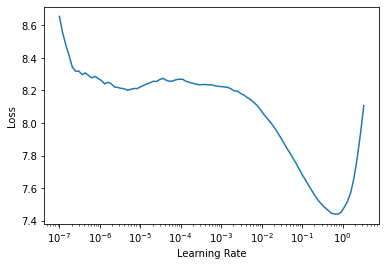

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 7e-2, moms=[0.8,0.7,0.8])

In [ ]:
learn.save('wm1')

In [ ]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/wm1.pth (deflated 23%)


In [ ]:
from google.colab import files
files.download("/content/models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
learn.validate()

(#2) [4.04564094543457,0.30051788687705994]